In [5]:
import pandas as pd

df = pd.read_csv("../data/raw/creditcard.csv")

class_counts = df["Class"].value_counts()
class_percent = df["Class"].value_counts(normalize=True) * 100

print("Class Distribution")
print("=" * 40)
print(f"Legitimate (0): {class_counts[0]:,} ({class_percent[0]:.4f}%)")
print(f"Fraudulent (1): {class_counts[1]:,} ({class_percent[1]:.4f}%)")
print(f"\nImbalance Ratio: 1:{class_counts[0] // class_counts[1]}")

Class Distribution
Legitimate (0): 284,315 (99.8273%)
Fraudulent (1): 492 (0.1727%)

Imbalance Ratio: 1:577


**Conclusion:**

The dataset is **highly imbalanced** — only **0.17%** of transactions are fraudulent (1 in every 577 samples).

If we model using this data there are high chances that our model will almost always predict the legitimate cases. While training the model, because majority of the class labels are usually legitimate it will be more biased towards predicting them.

## SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is a technique to handle class imbalance by **generating synthetic samples** for the minority class (fraud) rather than simply duplicating existing ones.

**How SMOTE works:**
1. For each minority sample, find its **k nearest neighbors** (default k=5) in the feature space
2. Randomly pick one of those neighbors
3. Create a **new synthetic sample** at a random point on the line segment between the original sample and the chosen neighbor
4. Repeat until the minority class is balanced with the majority class

**Why SMOTE over Random Oversampling?**
- **Random Oversampling** duplicates existing fraud samples exactly → leads to **overfitting** (model memorizes the same few fraud cases)
- **SMOTE** creates new, slightly different samples → model learns a **broader decision boundary** around fraud patterns

**Important:**
- SMOTE must be applied **only on the training set**, never on the test set. Otherwise we leak synthetic data into evaluation and get misleading metrics.
- After SMOTE, the training set will have a **50:50 class ratio** (equal fraud and legitimate samples)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Scale Time and Amount (V1-V28 already scaled via PCA)
scaler = StandardScaler()
X["Scaled_Amount"] = scaler.fit_transform(X["Amount"].values.reshape(-1, 1))
X["Scaled_Time"] = scaler.fit_transform(X["Time"].values.reshape(-1, 1))
X.drop(["Time", "Amount"], axis=1, inplace=True)

# Train-Test Split (stratified to preserve fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.4f}%)")
print(f"  Fraudulent:   {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.4f}%)")

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"  Training set: {X_train_smote.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train_smote == 0).sum():,} ({(y_train_smote == 0).mean()*100:.2f}%)")
print(f"  Fraudulent:   {(y_train_smote == 1).sum():,} ({(y_train_smote == 1).mean()*100:.2f}%)")
print(f"\n  Test set (untouched): {X_test.shape[0]:,} samples")

Before SMOTE:
  Training set: 227,845 samples
  Legitimate:   227,451 (99.8271%)
  Fraudulent:   394 (0.1729%)

After SMOTE:
  Training set: 454,902 samples
  Legitimate:   227,451 (50.00%)
  Fraudulent:   227,451 (50.00%)

  Test set (untouched): 56,962 samples


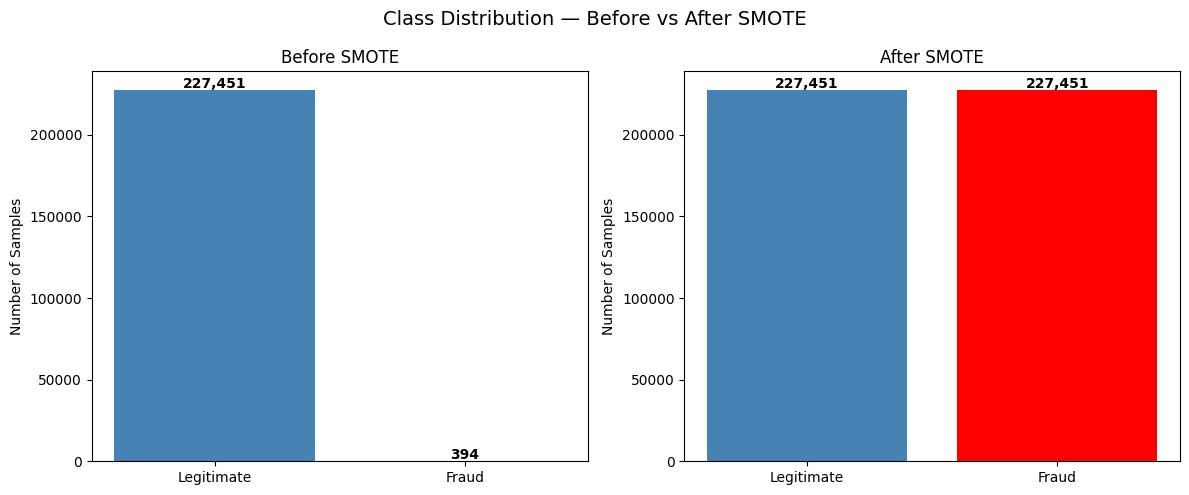

In [7]:
# Visualize class distribution: Before vs After SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(["Legitimate", "Fraud"], [y_train.value_counts()[0], y_train.value_counts()[1]], color=["steelblue", "red"])
axes[0].set_title("Before SMOTE")
axes[0].set_ylabel("Number of Samples")
for i, v in enumerate([y_train.value_counts()[0], y_train.value_counts()[1]]):
    axes[0].text(i, v + 1000, f"{v:,}", ha="center", fontweight="bold")

axes[1].bar(["Legitimate", "Fraud"], [y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]], color=["steelblue", "red"])
axes[1].set_title("After SMOTE")
axes[1].set_ylabel("Number of Samples")
for i, v in enumerate([y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]]):
    axes[1].text(i, v + 1000, f"{v:,}", ha="center", fontweight="bold")

plt.suptitle("Class Distribution — Before vs After SMOTE", fontsize=14)
plt.tight_layout()
plt.show()

## Random Undersampling

Random Undersampling is the opposite approach to SMOTE — instead of creating more minority samples, we **reduce the majority class** to match the minority class count.

**How it works:**
1. Count the number of minority (fraud) samples — in our case **~393 in training**
2. Randomly select the same number of samples from the majority (legitimate) class
3. Combine them to form a balanced training set

**Pros:**
- **Fast** — no synthetic data generation, just sampling
- **Smaller dataset** — much faster model training (from ~227K to ~786 samples)
- Works well when the majority class has a lot of **redundant/similar** samples

**Cons:**
- **Information loss** — we discard ~99.8% of legitimate transactions, potentially losing important patterns
- Model may not generalize well because it has seen very few legitimate examples
- Results can vary depending on which samples are randomly selected

**When to use Undersampling vs SMOTE:**
- Use **Undersampling** for quick prototyping, baseline models, and when training time matters
- Use **SMOTE** for production models where you want the model to learn from all available data
- Best practice: **compare both** and pick what gives better recall on the test set

In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Apply Random Undersampling only on training data
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("Before Undersampling:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.4f}%)")
print(f"  Fraudulent:   {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.4f}%)")

print(f"\nAfter Undersampling:")
print(f"  Training set: {X_train_under.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train_under == 0).sum():,} ({(y_train_under == 0).mean()*100:.2f}%)")
print(f"  Fraudulent:   {(y_train_under == 1).sum():,} ({(y_train_under == 1).mean()*100:.2f}%)")
print(f"\n  Test set (untouched): {X_test.shape[0]:,} samples")

Before Undersampling:
  Training set: 227,845 samples
  Legitimate:   227,451 (99.8271%)
  Fraudulent:   394 (0.1729%)

After Undersampling:
  Training set: 788 samples
  Legitimate:   394 (50.00%)
  Fraudulent:   394 (50.00%)

  Test set (untouched): 56,962 samples


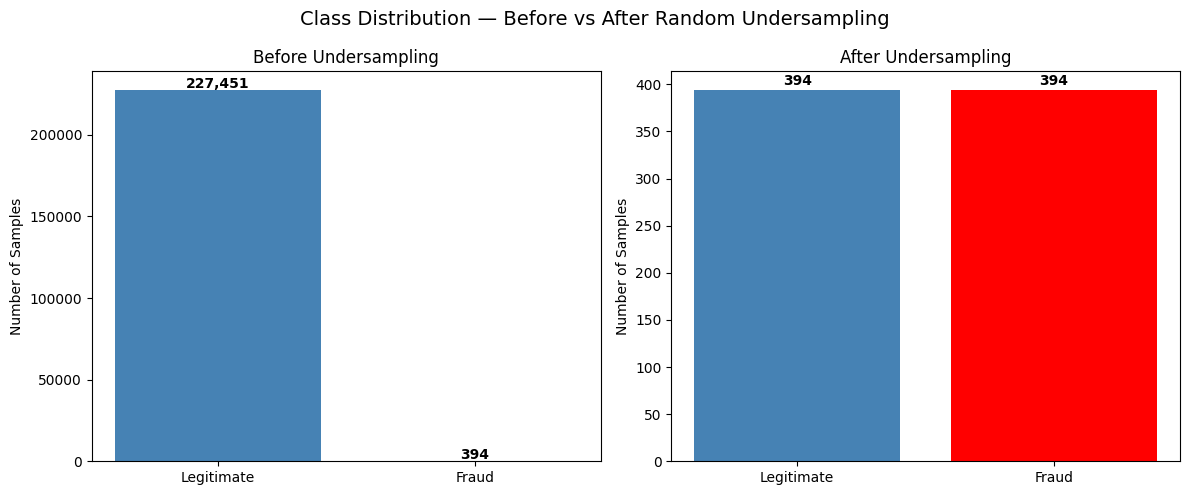

In [9]:
# Visualize: Before vs After Undersampling
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(["Legitimate", "Fraud"], [y_train.value_counts()[0], y_train.value_counts()[1]], color=["steelblue", "red"])
axes[0].set_title("Before Undersampling")
axes[0].set_ylabel("Number of Samples")
for i, v in enumerate([y_train.value_counts()[0], y_train.value_counts()[1]]):
    axes[0].text(i, v + 1000, f"{v:,}", ha="center", fontweight="bold")

axes[1].bar(["Legitimate", "Fraud"], [y_train_under.value_counts()[0], y_train_under.value_counts()[1]], color=["steelblue", "red"])
axes[1].set_title("After Undersampling")
axes[1].set_ylabel("Number of Samples")
for i, v in enumerate([y_train_under.value_counts()[0], y_train_under.value_counts()[1]]):
    axes[1].text(i, v + 5, f"{v:,}", ha="center", fontweight="bold")

plt.suptitle("Class Distribution — Before vs After Random Undersampling", fontsize=14)
plt.tight_layout()
plt.show()

## Class Weights

Unlike SMOTE and Undersampling which modify the data, Class Weights modify the **loss function** during training to make the model **pay more attention** to the minority class.

**How it works:**
- During training, each misclassification contributes to the loss (error) the model tries to minimize
- By default, misclassifying a fraud case and misclassifying a legitimate case are penalized **equally**
- With class weights, misclassifying a **fraud case is penalized much more heavily** (e.g., 577x more for our dataset)
- This forces the model to prioritize getting fraud cases right

**The `balanced` formula:**
```
weight = total_samples / (n_classes * class_count)

Legitimate weight = 284,807 / (2 * 284,315) = 0.5009
Fraud weight      = 284,807 / (2 * 492)     = 289.44
```
Misclassifying 1 fraud case costs the model ~**578x more** than misclassifying 1 legitimate case.

**Pros:**
- **No data modification** — uses the original dataset as-is, no synthetic samples or data loss
- **Simple** — just pass `class_weight="balanced"` to scikit-learn models
- **Works with any model** that supports it (Logistic Regression, Random Forest, SVM, XGBoost via `scale_pos_weight`)

**Cons:**
- Not all algorithms support class weights natively
- Can lead to more **false positives** (model becomes overly cautious, flagging legitimate transactions as fraud)
- Less control over the exact trade-off compared to threshold tuning

**SMOTE vs Undersampling vs Class Weights:**

| Approach | Data Modified? | Training Size | Risk |
|---|---|---|---|
| SMOTE | Yes (adds synthetic) | ~454K (2x fraud) | Synthetic noise, slower training |
| Undersampling | Yes (removes majority) | ~786 (tiny) | Information loss |
| Class Weights | No | ~227K (original) | More false positives |

In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights
classes = np.array([0, 1])
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

print("Computed Class Weights (balanced)")
print("=" * 45)
print(f"  Legitimate (0): {class_weight_dict[0]:.4f}")
print(f"  Fraudulent (1): {class_weight_dict[1]:.4f}")
print(f"\n  Fraud penalty is {class_weight_dict[1] / class_weight_dict[0]:.1f}x higher than legitimate")

Computed Class Weights (balanced)
  Legitimate (0): 0.5009
  Fraudulent (1): 289.1434

  Fraud penalty is 577.3x higher than legitimate


## Evaluation: SMOTE vs Undersampling vs Class Weights

We train a **Logistic Regression** model with each approach and compare them on the **same test set** using fraud-relevant metrics: Recall, Precision, F1-Score, and PR-AUC.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score
)
import time

results = {}

# --- 1. SMOTE ---
start = time.time()
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lr_smote.predict(X_test)
y_prob_smote = lr_smote.predict_proba(X_test)[:, 1]
train_time_smote = time.time() - start

precision_sm, recall_sm, _ = precision_recall_curve(y_test, y_prob_smote)
results["SMOTE"] = {
    "Precision": precision_score(y_test, y_pred_smote),
    "Recall": recall_score(y_test, y_pred_smote),
    "F1-Score": f1_score(y_test, y_pred_smote),
    "ROC-AUC": roc_auc_score(y_test, y_prob_smote),
    "PR-AUC": auc(recall_sm, precision_sm),
    "Train Time (s)": round(train_time_smote, 2)
}

# --- 2. Undersampling ---
start = time.time()
lr_under = LogisticRegression(max_iter=1000, random_state=42)
lr_under.fit(X_train_under, y_train_under)
y_pred_under = lr_under.predict(X_test)
y_prob_under = lr_under.predict_proba(X_test)[:, 1]
train_time_under = time.time() - start

precision_un, recall_un, _ = precision_recall_curve(y_test, y_prob_under)
results["Undersampling"] = {
    "Precision": precision_score(y_test, y_pred_under),
    "Recall": recall_score(y_test, y_pred_under),
    "F1-Score": f1_score(y_test, y_pred_under),
    "ROC-AUC": roc_auc_score(y_test, y_prob_under),
    "PR-AUC": auc(recall_un, precision_un),
    "Train Time (s)": round(train_time_under, 2)
}

# --- 3. Class Weights ---
start = time.time()
lr_cw = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
lr_cw.fit(X_train, y_train)
y_pred_cw = lr_cw.predict(X_test)
y_prob_cw = lr_cw.predict_proba(X_test)[:, 1]
train_time_cw = time.time() - start

precision_cw, recall_cw, _ = precision_recall_curve(y_test, y_prob_cw)
results["Class Weights"] = {
    "Precision": precision_score(y_test, y_pred_cw),
    "Recall": recall_score(y_test, y_pred_cw),
    "F1-Score": f1_score(y_test, y_pred_cw),
    "ROC-AUC": roc_auc_score(y_test, y_prob_cw),
    "PR-AUC": auc(recall_cw, precision_cw),
    "Train Time (s)": round(train_time_cw, 2)
}

# Display comparison
results_df = pd.DataFrame(results).T
results_df[["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"]] = results_df[["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"]].round(4)

print("Model Comparison: Logistic Regression")
print("=" * 75)
results_df

Model Comparison: Logistic Regression


,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Train Time (s)
SMOTE,0.0581,0.9184,0.1094,0.9698,0.7703,0.4
Undersampling,0.0384,0.9184,0.0738,0.9760,0.7172,0.0
Class Weights,0.0609,0.9184,0.1141,0.9722,0.7639,0.2


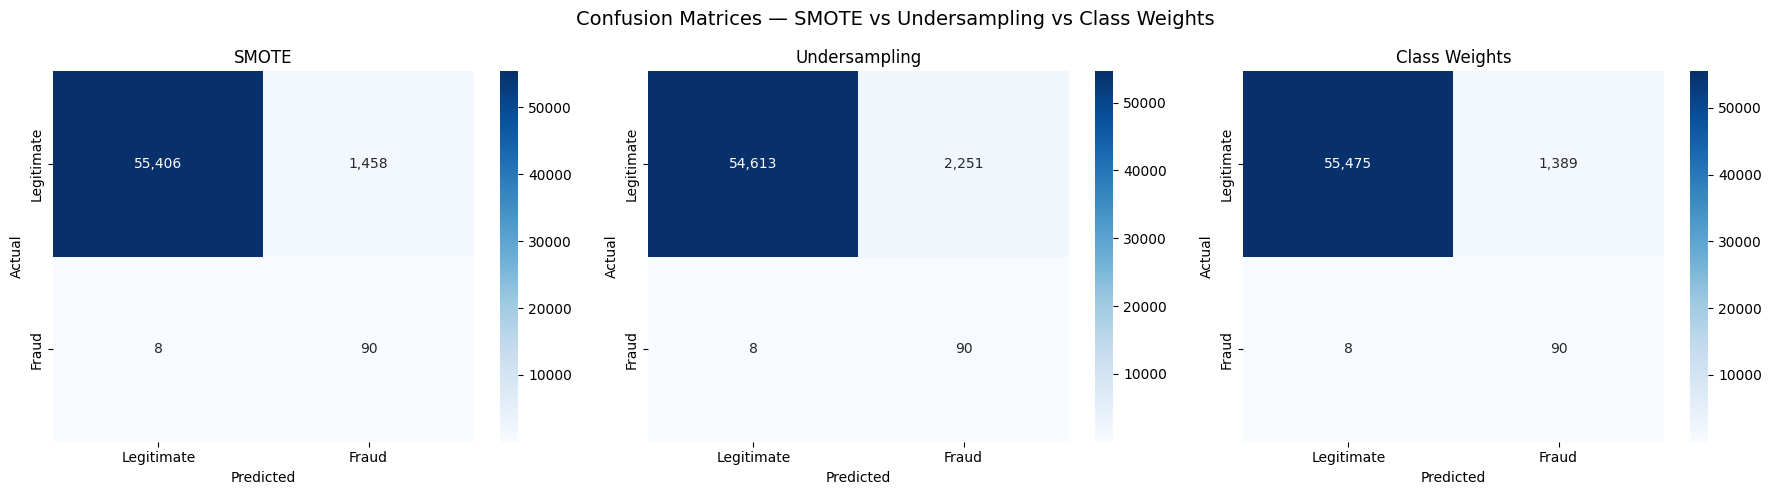

In [12]:
# Confusion Matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, y_pred) in zip(axes, [("SMOTE", y_pred_smote), ("Undersampling", y_pred_under), ("Class Weights", y_pred_cw)]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=",d", cmap="Blues", ax=ax,
                xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
    ax.set_title(f"{name}")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")

plt.suptitle("Confusion Matrices — SMOTE vs Undersampling vs Class Weights", fontsize=14)
plt.tight_layout()
plt.show()

**Confusion Matrix Breakdown**

| Metric | SMOTE | Undersampling | Class Weights |
|---|---|---|---|
| (actual legit → predicted legit) | 55,406 | 54,613 | 55,475 |
| (actual legit → predicted fraud) | 1,458 | 2,251 | 1,389 |
| (actual fraud → predicted legit) | 8 | 8 | 8 |
| (actual fraud → predicted fraud) | 90 | 90 | 90 |

**Few Observations**

1. Since our major goal is to classify the fraud cases. The point of concern will be if the fraud cases are classified as legit from our model. For the logistic regression model, for the three approaches there are 8 instances where the fraud cases were classified as legit.

2. If we are focussing on the model's ability in classifiying the acutal legit cases as fraud then Class Weights is the winner followed by SMOTE and then Undersampling. Class weights classifies only 1,389 legit cases as fraud, Undersampling classifies 2,251 legit cases as fraud. 
</br>
</br>
Now, Why this matters: Becasue if there is a genuine transaction present the model might flag it as fraud, leading to potential blocking of the transaction or throwing it for review. If at all the transactions are flagged for review then using Class weights we can have less reviews than Undersampling or SMOTE based approaches.

3. Precision is lowest across all the approaches.

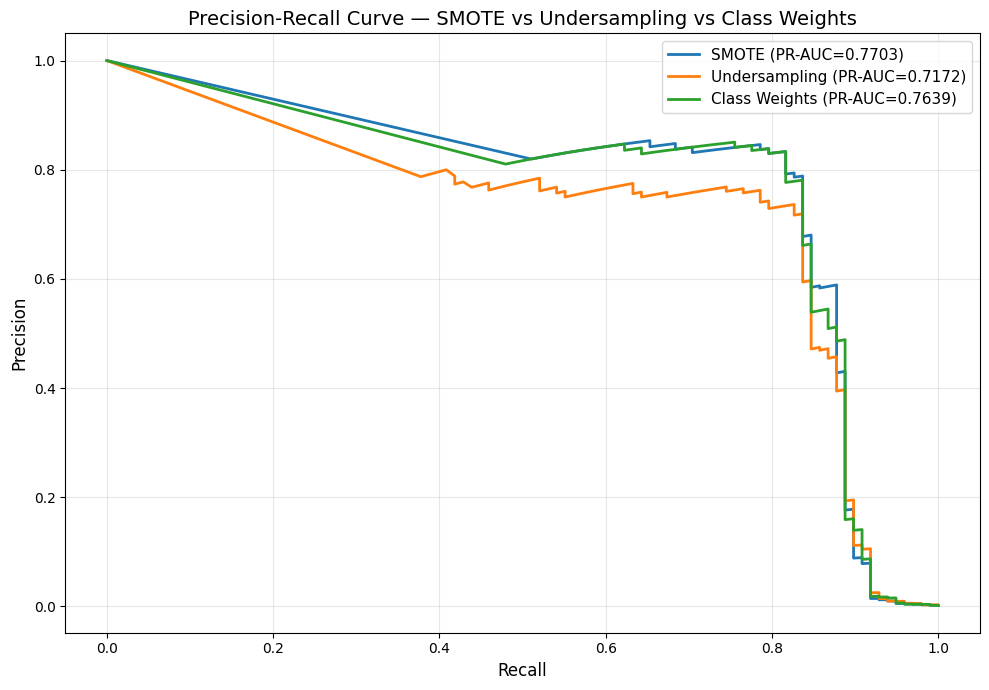

In [13]:
# Precision-Recall Curves comparison
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(recall_sm, precision_sm, label=f"SMOTE (PR-AUC={results['SMOTE']['PR-AUC']:.4f})", linewidth=2)
ax.plot(recall_un, precision_un, label=f"Undersampling (PR-AUC={results['Undersampling']['PR-AUC']:.4f})", linewidth=2)
ax.plot(recall_cw, precision_cw, label=f"Class Weights (PR-AUC={results['Class Weights']['PR-AUC']:.4f})", linewidth=2)

ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.set_title("Precision-Recall Curve — SMOTE vs Undersampling vs Class Weights", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

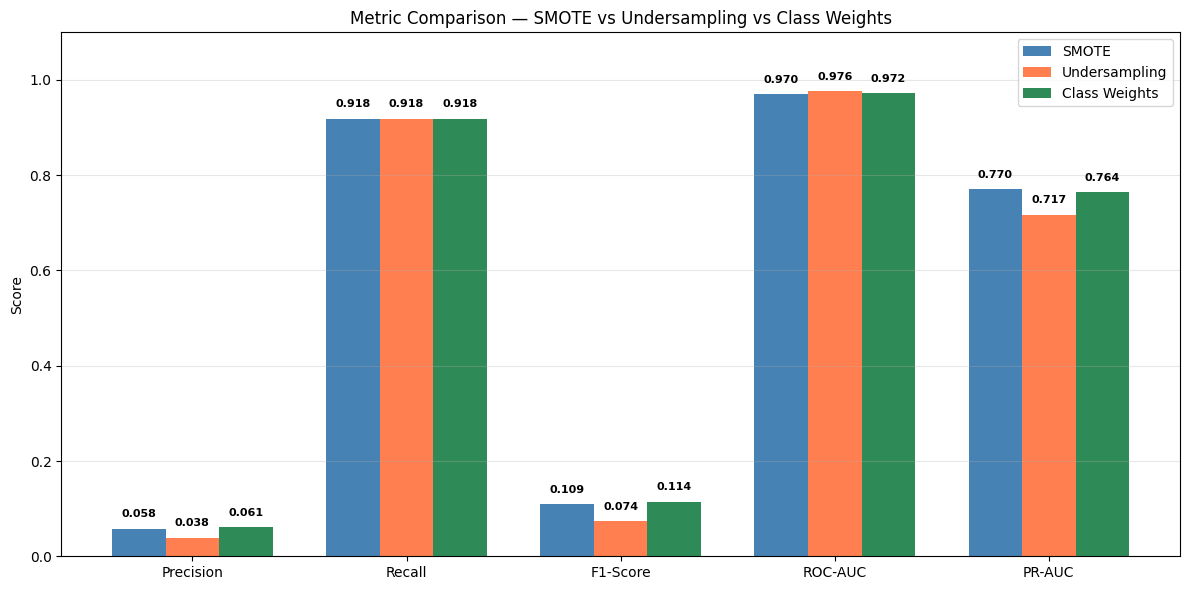

In [14]:
# Bar chart comparison of key metrics
metrics = ["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"]
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, [results["SMOTE"][m] for m in metrics], width, label="SMOTE", color="steelblue")
bars2 = ax.bar(x, [results["Undersampling"][m] for m in metrics], width, label="Undersampling", color="coral")
bars3 = ax.bar(x + width, [results["Class Weights"][m] for m in metrics], width, label="Class Weights", color="seagreen")

ax.set_ylabel("Score")
ax.set_title("Metric Comparison — SMOTE vs Undersampling vs Class Weights")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis="y", alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02, f"{height:.3f}",
                ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "precision", "recall", "roc_auc"]

# Build pipelines so resampling happens INSIDE each fold (no data leakage)
pipelines = {
    "SMOTE": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("lr", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Class Weights": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    )
}

cv_results = {}
for name, pipeline in pipelines.items():
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    cv_results[name] = {
        "Precision": f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
        "Recall": f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
        "F1-Score": f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
        "ROC-AUC": f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
    }

cv_df = pd.DataFrame(cv_results).T
print("5-Fold Stratified Cross-Validation Results (Logistic Regression)")
print("=" * 70)
cv_df

5-Fold Stratified Cross-Validation Results (Logistic Regression)


,Precision,Recall,F1-Score,ROC-AUC
SMOTE,0.0583 ± 0.0032,0.9163 ± 0.0204,0.1095 ± 0.0056,0.9802 ± 0.0128
Class Weights,0.0629 ± 0.0035,0.9138 ± 0.0230,0.1176 ± 0.0060,0.9825 ± 0.0101


We see for all the metrics the class weights perform better than SMOTE for logistic regression. The ranges for both the sampling methods are somewhat similar.So, taking class weights into account we we penalize the misclassification more heavily rather than introducing the synthetic data thorugh SMOTE

In [17]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "precision", "recall", "roc_auc"]

# Random Forest pipelines
rf_pipelines = {
    "RF + SMOTE": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "RF + Class Weights": RandomForestClassifier(
        class_weight="balanced", n_estimators=100, random_state=42, n_jobs=-1
    ),
}

rf_cv_results = {}
for name, pipeline in rf_pipelines.items():
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    rf_cv_results[name] = {
        "Precision": f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
        "Recall": f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
        "F1-Score": f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
        "ROC-AUC": f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
    }

rf_cv_df = pd.DataFrame(rf_cv_results).T
print("5-Fold Stratified CV — Random Forest: SMOTE vs Class Weights")
print("=" * 70)
rf_cv_df

5-Fold Stratified CV — Random Forest: SMOTE vs Class Weights


,Precision,Recall,F1-Score,ROC-AUC
RF + SMOTE,0.8820 ± 0.0328,0.7995 ± 0.0591,0.8368 ± 0.0291,0.9779 ± 0.0142
RF + Class Weights,0.9469 ± 0.0288,0.7488 ± 0.0289,0.8355 ± 0.0151,0.9530 ± 0.0131


For the case of RandonForestClassifier the the Precision is better for Class Weights rather than SMOTE, however recall is better for SMOTE. We can say from the ROC-AUC that  the Class Weights the classifies the fraud more correctly but also misses few cases, but SMOTE ranks the fraud probability better but also gives us false alarms. F1-Score is nearly the same for both.

In [19]:
from xgboost import XGBClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "precision", "recall", "roc_auc"]

# scale_pos_weight = count(legitimate) / count(fraud) ≈ 577
scale_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipelines = {
    "XGB + SMOTE": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("xgb", XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss", n_jobs=-1))
    ]),
    "XGB + Class Weights": XGBClassifier(
        scale_pos_weight=scale_ratio, n_estimators=100, random_state=42,
        eval_metric="logloss", n_jobs=-1
    ),
}

xgb_cv_results = {}
for name, pipeline in xgb_pipelines.items():
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    xgb_cv_results[name] = {
        "Precision": f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
        "Recall": f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
        "F1-Score": f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
        "ROC-AUC": f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
    }

xgb_cv_df = pd.DataFrame(xgb_cv_results).T
print("5-Fold Stratified CV — XGBoost: SMOTE vs Class Weights (scale_pos_weight)")
print("=" * 75)
xgb_cv_df

5-Fold Stratified CV — XGBoost: SMOTE vs Class Weights (scale_pos_weight)


,Precision,Recall,F1-Score,ROC-AUC
XGB + SMOTE,0.7428 ± 0.0287,0.8274 ± 0.0366,0.7818 ± 0.0150,0.9790 ± 0.0099
XGB + Class Weights,0.9133 ± 0.0441,0.8147 ± 0.0335,0.8595 ± 0.0059,0.9792 ± 0.0096


For XGBoost, Class Weights (via scale_pos_weight) outperforms SMOTE on Precision (0.91 vs 0.74) and F1-Score (0.86 vs 0.78), while SMOTE has a slight edge on Recall (0.83 vs 0.81). ROC-AUC is virtually identical (~0.979) for both approaches. Notably, Class Weights also has a much lower standard deviation on F1 (±0.006 vs ±0.015), indicating more stable performance across folds. Overall, Class Weights is the stronger choice for XGBoost — it maintains high fraud detection while producing significantly fewer false alarms.

#### Comparing Logisitic Regression, RandomForest and XGBoost

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "precision", "recall", "roc_auc"]

scale_ratio = (y_train == 0).sum() / (y_train == 1).sum()

models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced", n_estimators=100, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=scale_ratio, n_estimators=100, random_state=42,
        eval_metric="logloss", n_jobs=-1
    ),
}

model_cv_results = {}
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    model_cv_results[name] = {
        "Precision": f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
        "Recall": f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
        "F1-Score": f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
        "ROC-AUC": f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
    }

model_cv_df = pd.DataFrame(model_cv_results).T
print("5-Fold Stratified CV — LR vs RF vs XGBoost (All with Class Weights)")
print("=" * 75)
model_cv_df

5-Fold Stratified CV — LR vs RF vs XGBoost (All with Class Weights)


,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.0629 ± 0.0035,0.9138 ± 0.0230,0.1176 ± 0.0060,0.9825 ± 0.0101
Random Forest,0.9469 ± 0.0288,0.7488 ± 0.0289,0.8355 ± 0.0151,0.9530 ± 0.0131
XGBoost,0.9133 ± 0.0441,0.8147 ± 0.0335,0.8595 ± 0.0059,0.9792 ± 0.0096


Analyzing this we see that the Logistic Regression has a high recall ~91%(ability to catch the fraud 91% of the time) while precision is very less ~ 6% i.e. the ability to classify out of every 100 transactions it flags a fraud only 6 are fraud actually. If we look at the F1-Score then we have that XGBoost performs well. So XGBoost the is the overall best model.

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import optuna

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

def objective(trial):
    # Define our model
    # Do our cross validation
    # Return our scores

    params = {
        "max_depth": trial.suggest_int('max_depth', 3, 10),
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.1),
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight',1,10),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }

    model = XGBClassifier(**params)


    score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    return score


In [25]:
# Create and run the optimization process
study = optuna.create_study(study_name='xgboost_study', direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True, n_jobs=-1)

# Get the best param value
best_params = study.best_params
print(f"The Best params : {best_params}")


[I 2026-02-14 17:52:15,896] A new study created in memory with name: xgboost_study
Best trial: 1. Best value: 0.981475:  10%|█         | 1/10 [00:22<03:19, 22.19s/it]

[I 2026-02-14 17:52:38,053] Trial 1 finished with value: 0.9814750047158267 and parameters: {'max_depth': 3, 'learning_rate': 0.09822893090720074, 'n_estimators': 202, 'subsample': 0.5875049626298411, 'colsample_bytree': 0.8930223760208039, 'min_child_weight': 5, 'gamma': 2.086151876996461}. Best is trial 1 with value: 0.9814750047158267.


Best trial: 1. Best value: 0.981475:  20%|██        | 2/10 [00:23<01:19,  9.93s/it]

[I 2026-02-14 17:52:39,448] Trial 3 finished with value: 0.9802229514284303 and parameters: {'max_depth': 4, 'learning_rate': 0.07117642819944175, 'n_estimators': 207, 'subsample': 0.8093548363148717, 'colsample_bytree': 0.6403058328830185, 'min_child_weight': 2, 'gamma': 0.9570145816379189}. Best is trial 1 with value: 0.9814750047158267.


Best trial: 1. Best value: 0.981475:  30%|███       | 3/10 [00:28<00:53,  7.61s/it]

[I 2026-02-14 17:52:44,296] Trial 6 finished with value: 0.9808981914974766 and parameters: {'max_depth': 10, 'learning_rate': 0.06496532487954822, 'n_estimators': 364, 'subsample': 0.6026061976119333, 'colsample_bytree': 0.7724870146579501, 'min_child_weight': 2, 'gamma': 4.263509892553345}. Best is trial 1 with value: 0.9814750047158267.


Best trial: 1. Best value: 0.981475:  40%|████      | 4/10 [00:28<00:28,  4.73s/it]

[I 2026-02-14 17:52:44,598] Trial 5 finished with value: 0.9806685156136595 and parameters: {'max_depth': 3, 'learning_rate': 0.08811662674751823, 'n_estimators': 451, 'subsample': 0.7956447963143706, 'colsample_bytree': 0.8520695516401093, 'min_child_weight': 9, 'gamma': 4.792010072372063}. Best is trial 1 with value: 0.9814750047158267.


Best trial: 0. Best value: 0.981693:  50%|█████     | 5/10 [00:30<00:18,  3.66s/it]

[I 2026-02-14 17:52:46,363] Trial 0 finished with value: 0.9816930353636371 and parameters: {'max_depth': 6, 'learning_rate': 0.013231685642974101, 'n_estimators': 283, 'subsample': 0.613519711222374, 'colsample_bytree': 0.8168830427772928, 'min_child_weight': 6, 'gamma': 2.7627668548027087}. Best is trial 0 with value: 0.9816930353636371.


Best trial: 0. Best value: 0.981693:  60%|██████    | 6/10 [00:31<00:11,  2.81s/it]

[I 2026-02-14 17:52:47,515] Trial 8 finished with value: 0.9814358932540225 and parameters: {'max_depth': 9, 'learning_rate': 0.037129597486044066, 'n_estimators': 327, 'subsample': 0.7020674914450789, 'colsample_bytree': 0.9275298488864268, 'min_child_weight': 10, 'gamma': 3.735317639879217}. Best is trial 0 with value: 0.9816930353636371.


Best trial: 0. Best value: 0.981693:  70%|███████   | 7/10 [00:32<00:06,  2.03s/it]

[I 2026-02-14 17:52:47,934] Trial 7 finished with value: 0.9805766878206651 and parameters: {'max_depth': 5, 'learning_rate': 0.014200749753758455, 'n_estimators': 355, 'subsample': 0.5725751616711627, 'colsample_bytree': 0.8974521093346363, 'min_child_weight': 10, 'gamma': 4.066055811953591}. Best is trial 0 with value: 0.9816930353636371.


Best trial: 4. Best value: 0.98259:  80%|████████  | 8/10 [00:35<00:04,  2.41s/it] 

[I 2026-02-14 17:52:51,155] Trial 4 finished with value: 0.9825901892759326 and parameters: {'max_depth': 6, 'learning_rate': 0.07340218139553491, 'n_estimators': 396, 'subsample': 0.8616584894763837, 'colsample_bytree': 0.8899312062448673, 'min_child_weight': 9, 'gamma': 0.21317426956189267}. Best is trial 4 with value: 0.9825901892759326.


Best trial: 9. Best value: 0.983349: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]

[I 2026-02-14 17:52:53,980] Trial 2 finished with value: 0.98144044222815 and parameters: {'max_depth': 3, 'learning_rate': 0.08370745550773688, 'n_estimators': 993, 'subsample': 0.5948404948624753, 'colsample_bytree': 0.7544420111139228, 'min_child_weight': 5, 'gamma': 4.453916208890999}. Best is trial 4 with value: 0.9825901892759326.
[I 2026-02-14 17:52:54,028] Trial 9 finished with value: 0.9833494847654192 and parameters: {'max_depth': 3, 'learning_rate': 0.07057606893976962, 'n_estimators': 895, 'subsample': 0.5840848661708049, 'colsample_bytree': 0.798665051877469, 'min_child_weight': 2, 'gamma': 3.1148910958810094}. Best is trial 9 with value: 0.9833494847654192.
The Best params : {'max_depth': 3, 'learning_rate': 0.07057606893976962, 'n_estimators': 895, 'subsample': 0.5840848661708049, 'colsample_bytree': 0.798665051877469, 'min_child_weight': 2, 'gamma': 3.1148910958810094}


In [26]:
study.best_params

{'max_depth': 3,
 'learning_rate': 0.07057606893976962,
 'n_estimators': 895,
 'subsample': 0.5840848661708049,
 'colsample_bytree': 0.798665051877469,
 'min_child_weight': 2,
 'gamma': 3.1148910958810094}

/var/folders/4s/z0hcx0pj2cn4rpt0g7sn00pr0000gp/T/ipykernel_79095/1716948956.py:3: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/var/folders/4s/z0hcx0pj2cn4rpt0g7sn00pr0000gp/T/ipykernel_79095/1716948956.py:4: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

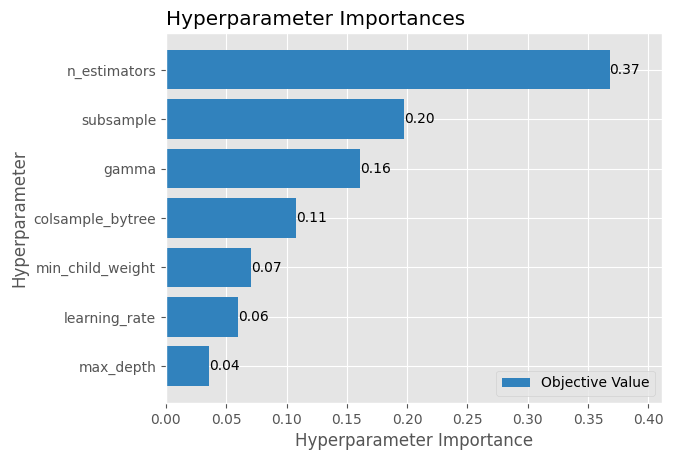

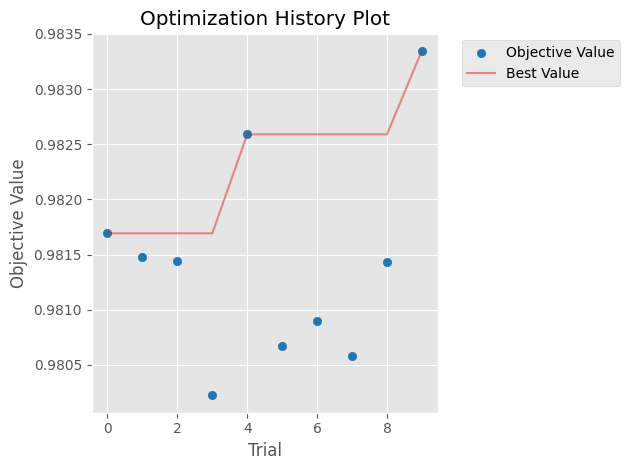

In [34]:
from optuna.visualization.matplotlib import plot_param_importances, plot_optimization_history

plot_param_importances(study)
plot_optimization_history(study)

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "precision", "recall", "roc_auc"]
scale_ratio = (y_train == 0).sum() / (y_train == 1).sum()
best_params = study.best_params

# Feature sets based on EDA correlation + mean shift analysis
tier1 = ["V17", "V14", "V12", "V10", "V16", "V3", "V7"]
tier2 = ["V11", "V4", "V18", "V1", "V9", "V5", "V2"]
tier3 = ["V6", "V21", "V19", "V20", "V8", "V27", "V28", "V25", "V26", "V22", "V23", "V24", "V13", "V15"]
all_features = tier1 + tier2 + tier3 + ["Scaled_Amount", "Scaled_Time"]

feature_sets = {
    "Tier 1 Only (7)": tier1,
    "Tier 1 + 2 (14)": tier1 + tier2,
    "Tier 1 + 2 + Scaled (16)": tier1 + tier2 + ["Scaled_Amount", "Scaled_Time"],
    "All Features (30)": all_features,
}

feature_results = {}
for name, features in feature_sets.items():
    model = XGBClassifier(
        **best_params,
        scale_pos_weight=scale_ratio,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
    scores = cross_validate(model, X_train[features], y_train, cv=cv, scoring=scoring)
    feature_results[name] = {
        "Precision": f"{scores['test_precision'].mean():.4f} ± {scores['test_precision'].std():.4f}",
        "Recall": f"{scores['test_recall'].mean():.4f} ± {scores['test_recall'].std():.4f}",
        "F1-Score": f"{scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}",
        "ROC-AUC": f"{scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}",
        "# Features": len(features),
    }

feature_df = pd.DataFrame(feature_results).T
print("XGBoost (Tuned) — Feature Set Comparison")
print("=" * 80)
feature_df

XGBoost (Tuned) — Feature Set Comparison


,Precision,Recall,F1-Score,ROC-AUC,# Features
Tier 1 Only (7),0.6940 ± 0.0428,0.8148 ± 0.0469,0.7470 ± 0.0123,0.9596 ± 0.0137,7
Tier 1 + 2 (14),0.7806 ± 0.0404,0.8275 ± 0.0426,0.8020 ± 0.0234,0.9752 ± 0.0140,14
Tier 1 + 2 + Scaled (16),0.8051 ± 0.0500,0.8300 ± 0.0427,0.8157 ± 0.0276,0.9790 ± 0.0117,16
All Features (30),0.8534 ± 0.0446,0.8300 ± 0.0343,0.8397 ± 0.0097,0.9826 ± 0.0119,30


Recall is nearly the same(~0.81-0.83) across all the tiers. Adding more features bearely imroves the fraud detection. The Precison is improved by adding in more features, it helps to reduce the false alarms not to catch more fraud. Out all all these tiers the tier with all features stand out , it has the highest F1-Score and with very less std deviation.The ROC value among all is the highest for tier using all the features.

In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Train final XGBoost model with Optuna's best params + class weight (all features)
best_params = study.best_params
scale_ratio = (y_train == 0).sum() / (y_train == 1).sum()

final_model = XGBClassifier(
    **best_params,
    scale_pos_weight=scale_ratio,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print("Final XGBoost Model — Test Set Evaluation (All 30 Features)")
print("=" * 60)
print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")
print(f"\nBest Params: {best_params}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Legitimate", "Fraud"]))

Threshold Tuning — Final XGBoost Model
           Precision  Recall  F1-Score  Fraud Caught  False Alarms
Threshold                                                         
0.3           0.7568  0.8571    0.8038          84.0          27.0
0.4           0.8077  0.8571    0.8317          84.0          20.0
0.45          0.8218  0.8469    0.8342          83.0          18.0
0.5           0.8283  0.8367    0.8325          82.0          17.0
0.55          0.8367  0.8367    0.8367          82.0          16.0
0.6           0.8454  0.8367    0.8410          82.0          15.0
0.65          0.8438  0.8265    0.8351          81.0          15.0
0.7           0.8526  0.8265    0.8394          81.0          14.0
0.8           0.8617  0.8265    0.8438          81.0          13.0

Best F1 Threshold: 0.8 (F1 = 0.8438)


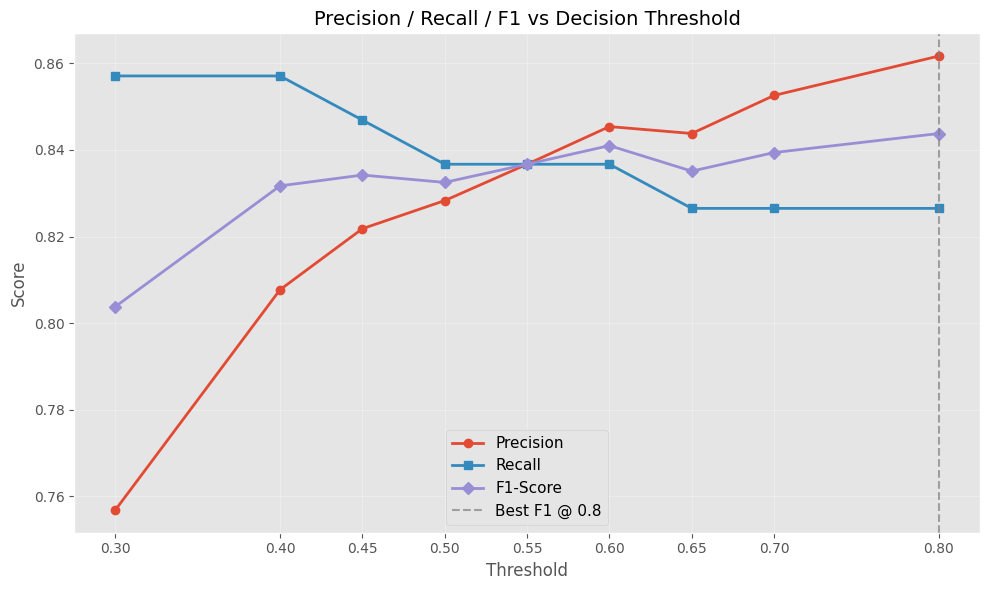

In [43]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

# Get probabilities from the final model
y_prob = final_model.predict_proba(X_test)[:, 1]

# Test multiple thresholds (finer-grained around 0.5-0.6 to find the peak)
thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8]

threshold_results = {}
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    threshold_results[f"{t}"] = {
        "Precision": round(precision_score(y_test, y_pred_t), 4),
        "Recall": round(recall_score(y_test, y_pred_t), 4),
        "F1-Score": round(f1_score(y_test, y_pred_t), 4),
        "Fraud Caught": int(y_pred_t[y_test == 1].sum()),
        "False Alarms": int(y_pred_t[y_test == 0].sum()),
    }

threshold_df = pd.DataFrame(threshold_results).T
threshold_df.index.name = "Threshold"
print("Threshold Tuning — Final XGBoost Model")
print("=" * 70)
print(threshold_df.to_string())

# Highlight the best F1 threshold
best_threshold = max(threshold_results, key=lambda t: threshold_results[t]["F1-Score"])
print(f"\nBest F1 Threshold: {best_threshold} (F1 = {threshold_results[best_threshold]['F1-Score']:.4f})")

# Plot Precision, Recall, F1 across thresholds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, [threshold_results[str(t)]["Precision"] for t in thresholds], "o-", label="Precision", linewidth=2)
ax.plot(thresholds, [threshold_results[str(t)]["Recall"] for t in thresholds], "s-", label="Recall", linewidth=2)
ax.plot(thresholds, [threshold_results[str(t)]["F1-Score"] for t in thresholds], "D-", label="F1-Score", linewidth=2)
ax.axvline(x=float(best_threshold), color="gray", linestyle="--", alpha=0.7, label=f"Best F1 @ {best_threshold}")
ax.set_xlabel("Threshold", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Precision / Recall / F1 vs Decision Threshold", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(thresholds)
plt.tight_layout()
plt.show()

**Threshold Analysis:**

Our goal is to **reduce false alarms** while **maintaining fraud detection**. The key observation is that between thresholds 0.5 and 0.6, fraud caught stays constant at 82 while false alarms drop from 17 to 15 — a free improvement with no trade-off.

**Chosen Threshold: 0.6**
- Catches **82 out of 98** frauds (same as default 0.5)
- Only **15 false alarms** — 12% fewer than default (17), with no fraud cases lost
- F1-Score: **0.8410** (highest before recall drops at 0.65)

At 0.65 and above, the model starts missing additional fraud cases (81 caught) without even reducing false alarms further (still 15 at 0.65). This makes **0.6 the optimal threshold** — it sits at the edge where we get maximum false alarm reduction before fraud detection begins to degrade.

Final XGBoost Model — Test Set (Threshold = 0.6)
  Precision: 0.8454
  Recall:    0.8367
  F1-Score:  0.8410
  ROC-AUC:   0.9809

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



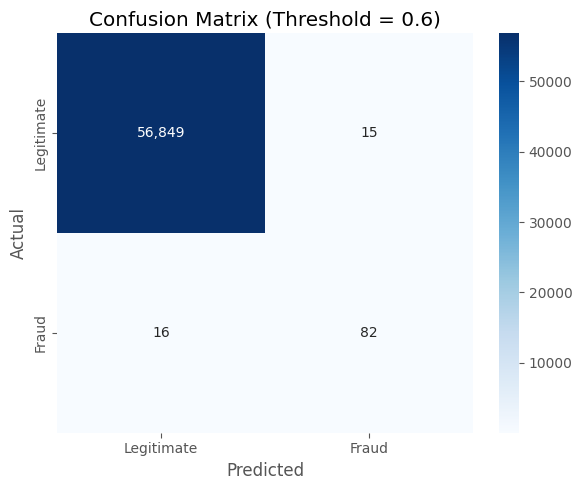

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Apply optimal threshold
OPTIMAL_THRESHOLD = 0.6
y_prob = final_model.predict_proba(X_test)[:, 1]
y_pred_tuned = (y_prob >= OPTIMAL_THRESHOLD).astype(int)

print(f"Final XGBoost Model — Test Set (Threshold = {OPTIMAL_THRESHOLD})")
print("=" * 60)
print(f"  Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=["Legitimate", "Fraud"]))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt=",d", cmap="Blues", ax=ax,
            xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
ax.set_title(f"Confusion Matrix (Threshold = {OPTIMAL_THRESHOLD})")
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
plt.tight_layout()
plt.show()

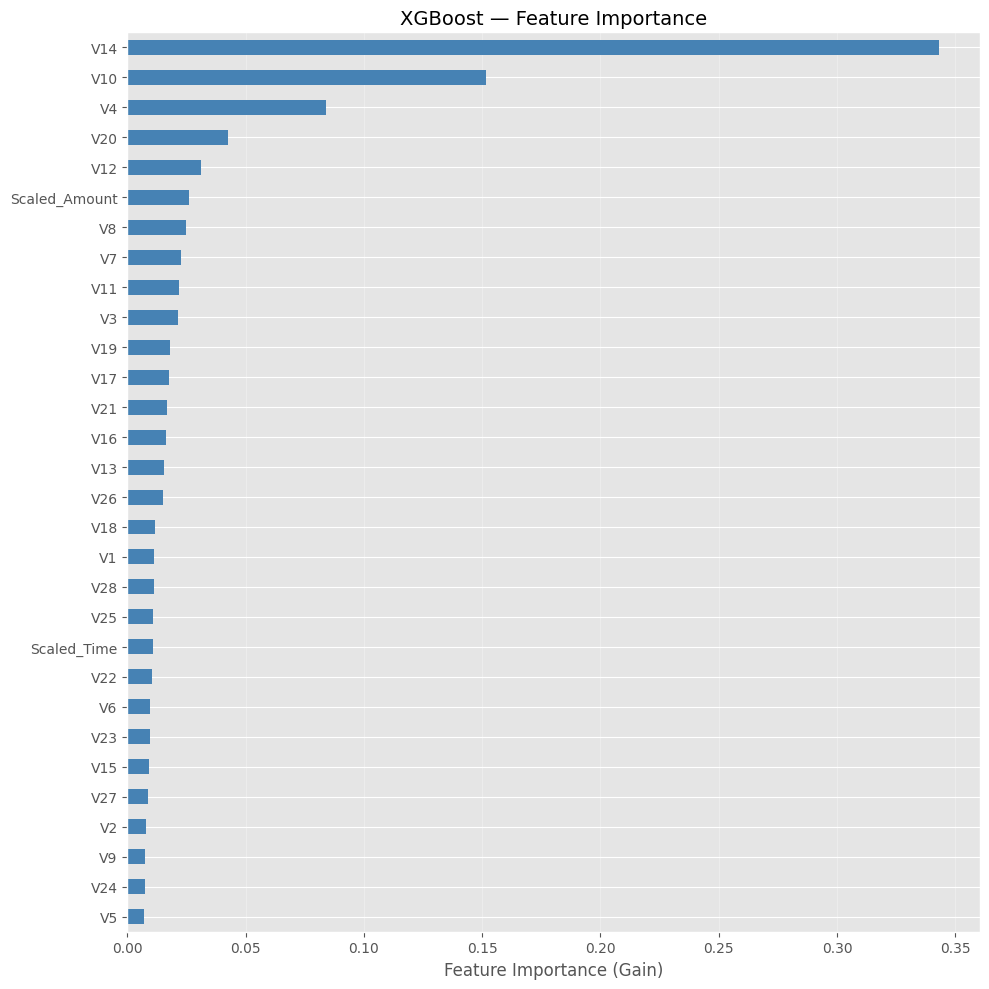

Top 10 Most Important Features:
  1. V14                  0.3433
  2. V10                  0.1518
  3. V4                   0.0839
  4. V20                  0.0425
  5. V12                  0.0309
  6. Scaled_Amount        0.0260
  7. V8                   0.0247
  8. V7                   0.0225
  9. V11                  0.0217
  10. V3                   0.0215


In [45]:
# Feature Importance — Final XGBoost Model
importances = final_model.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 10))
feat_imp.plot(kind="barh", ax=ax, color="steelblue")
ax.set_xlabel("Feature Importance (Gain)", fontsize=12)
ax.set_title("XGBoost — Feature Importance", fontsize=14)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# Top 10 features
print("Top 10 Most Important Features:")
print("=" * 40)
for i, (feat, imp) in enumerate(feat_imp.sort_values(ascending=False).head(10).items(), 1):
    print(f"  {i}. {feat:20s} {imp:.4f}")

In [46]:
import joblib

# Save the final model and optimal threshold together
model_artifact = {
    "model": final_model,
    "threshold": OPTIMAL_THRESHOLD,
    "features": list(X_train.columns),
    "best_params": study.best_params,
}

joblib.dump(model_artifact, "../models/xgboost_fraud_detector.joblib")
print("Model saved to models/xgboost_fraud_detector.joblib")
print(f"  Threshold: {OPTIMAL_THRESHOLD}")
print(f"  Features:  {len(X_train.columns)}")
print(f"  Params:    {study.best_params}")

Model saved to models/xgboost_fraud_detector.joblib
  Threshold: 0.6
  Features:  30
  Params:    {'max_depth': 3, 'learning_rate': 0.07057606893976962, 'n_estimators': 895, 'subsample': 0.5840848661708049, 'colsample_bytree': 0.798665051877469, 'min_child_weight': 2, 'gamma': 3.1148910958810094}
